- Name: Anand Mahadevan
- SID: 862132182

- Source: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

**Question 1: k-means Clustering [10pts]**

I implemented Lloyd's algorithm for k-means clustering along with the k-means++ initialization method from scratch. I scaled the features, and evaluated the performance of k-means for $k$ ranging from 1 to 5. The performance was measured using the silhouette coefficient, averaging the results over 10 runs with different initializations. For $k = 1$, I set the silhouette score to 0 to include it in the plot. The results were visualized with error bars, comparing the random initialization and k-means++ initialization methods.

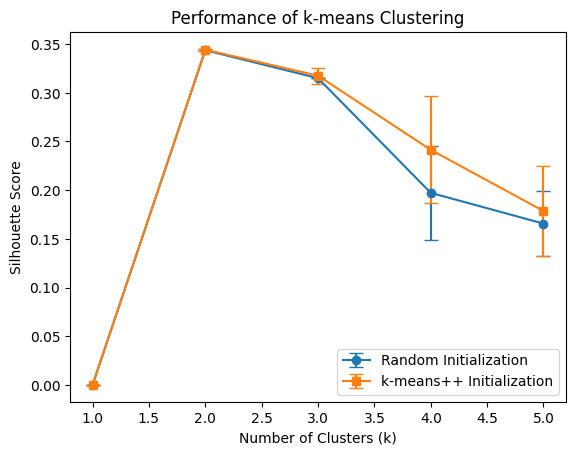

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
import random

breast_cancer_data = load_breast_cancer()
X = breast_cancer_data.data
y = breast_cancer_data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# centroids for k-means clustering
def init_centroids(X, k, init='random'):
    if init == 'k-means++':
        centroids = [X[np.random.choice(range(X.shape[0]))]]
        for _ in range(1, k):
            dist_sq = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = random.random()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(X[j])
                    break
        centroids = np.array(centroids)
    elif init == 'random':
        indices = np.random.choice(X.shape[0], k, replace=False)
        centroids = X[indices]
    return centroids

# k-means clustering
def k_means(X, k, init='random', max_iterations=300):
    centroids = init_centroids(X, k, init)
    for _ in range(max_iterations):
        distances = np.array([[np.linalg.norm(x - centroid) for centroid in centroids] for x in X])
        clusters = np.argmin(distances, axis=1)
        new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return clusters, centroids

# k-means clustering and compute silhouette scores
def evaluate_k_means(X, k, init='random', n_runs=10):
    if k == 1: # silhouette score not defined for a single cluster
        return 0, 0
    silhouette_scores = []
    for _ in range(n_runs):
        clusters, _ = k_means(X, k, init)
        score = silhouette_score(X, clusters)
        silhouette_scores.append(score)
    return np.mean(silhouette_scores), np.std(silhouette_scores)

k_values = range(1, 6)
random_means, random_stds = [], []
kmeanspp_means, kmeanspp_stds = [], []

for k in k_values:
    mean, std = evaluate_k_means(X_scaled, k, init='random')
    random_means.append(mean)
    random_stds.append(std)

    mean, std = evaluate_k_means(X_scaled, k, init='k-means++')
    kmeanspp_means.append(mean)
    kmeanspp_stds.append(std)

# plotting with error bars
plt.errorbar(k_values, random_means, yerr=random_stds, label='Random Initialization', fmt='o-', capsize=5)
plt.errorbar(k_values, kmeanspp_means, yerr=kmeanspp_stds, label='k-means++ Initialization', fmt='s-', capsize=5)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Performance of k-means Clustering')
plt.legend()
plt.show()


**Question 2: Density-based clustering with DBSCAN [15pts]**

For this question, I implemented the DBSCAN algorithm from scratch. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that identifies clusters in a dataset based on the density of data points. The algorithm has two main parameters: Eps (the maximum distance between two samples for one to be considered as in the neighborhood of the other) and MinPts (the minimum number of samples in a neighborhood for a point to be considered as a core point). I chose Eps values of 2 and 4, as Eps = 2 is when I observed meaningful clusters starting to appear.

**Error is close to 0, so the error bars don't show!**



Eps = 2, MinPts = (5, 10, 15, 20), Means = (-0.2745785230150305, -0.23385633789862853, -0.19298309251943918, -0.18968003391153737), STDs = (5.551115123125783e-17, 2.7755575615628914e-17, 0.0, 0.0)
Eps = 4, MinPts = (5, 10, 15, 20), Means = (-0.07547319540565636, -0.07894542431143516, -0.08131625028213496, -0.07166971090008022), STDs = (0.0, 0.0, 0.0, 0.0)


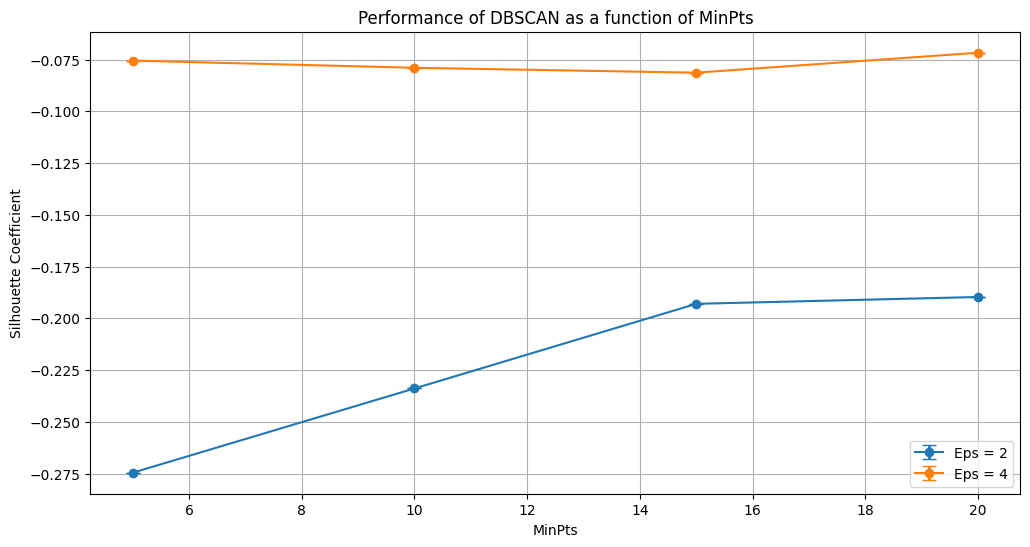

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

data = load_breast_cancer()
X = data.data
y = data.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

class DBSCAN:
    def __init__(self, eps, min_pts):
        self.eps = eps
        self.min_pts = min_pts
        self.labels = None

    def fit(self, X):
        n = X.shape[0]
        self.labels = -1 * np.ones(n)  # init labels as unclassified
        cluster_id = 0

        for i in range(n):
            if self.labels[i] != -1:
                continue

            neighbors = self.region_query(X, i)
            if len(neighbors) < self.min_pts:
                self.labels[i] = -1  # mark as noise
            else:
                self.expand_cluster(X, i, neighbors, cluster_id)
                cluster_id += 1

    def region_query(self, X, point_idx):
        neighbors = []
        for i in range(X.shape[0]):
            if euclidean_distance(X[point_idx], X[i]) < self.eps:
                neighbors.append(i)
        return neighbors

    def expand_cluster(self, X, point_idx, neighbors, cluster_id):
        self.labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if self.labels[neighbor] == -1:
                self.labels[neighbor] = cluster_id
            elif self.labels[neighbor] == -1:
                self.labels[neighbor] = cluster_id
                new_neighbors = self.region_query(X, neighbor)
                if len(new_neighbors) >= self.min_pts:
                    neighbors += new_neighbors
            i += 1

    def get_labels(self):
        return self.labels

# performance of DBSCAN
def evaluate_dbscan(X, eps_values, min_pts_values, n_runs=10):
    results = {eps: [] for eps in eps_values}

    for eps in eps_values:
        for min_pts in min_pts_values:
            silhouettes = []
            for _ in range(n_runs):
                dbscan = DBSCAN(eps, min_pts)
                dbscan.fit(X)
                labels = dbscan.get_labels()
                if len(set(labels)) > 1:
                    silhouette_avg = silhouette_score(X, labels)
                    silhouettes.append(silhouette_avg)
                else:
                    silhouettes.append(-1)
            results[eps].append((min_pts, np.mean(silhouettes), np.std(silhouettes)))
    return results

eps_values = [2, 4]
min_pts_values = [5, 10, 15, 20]
results = evaluate_dbscan(X_scaled, eps_values, min_pts_values)

plt.figure(figsize=(12, 6))

for eps in eps_values:
    min_pts, means, stds = zip(*results[eps])
    print(f"Eps = {eps}, MinPts = {min_pts}, Means = {means}, STDs = {stds}")
    plt.errorbar(min_pts, means, yerr=stds, label=f'Eps = {eps}', marker='o', capsize=5, elinewidth=2)

plt.xlabel('MinPts')
plt.ylabel('Silhouette Coefficient')
plt.title('Performance of DBSCAN as a function of MinPts')
plt.legend()
plt.grid(True)
plt.show()

**Question 3: Graph-based clustering with Spectral Clustering [10pts]**

I constructed the affinity matrix using a Gaussian similarity function, considering pairwise distances between data points. Then, I computed the Laplacian matrix based on the affinity matrix. Next, I performed eigendecomposition on the Laplacian matrix to obtain the eigenvectors corresponding to the smallest eigenvalues. Utilizing these eigenvectors, I applied KMeans clustering to partition the data into clusters. Finally, I evaluated the performance of spectral clustering by computing the silhouette score averaged over multiple trials for different values of the number of clusters $k$ and the Gaussian similarity parameter $\sigma$. The results were then plotted, showing the performance of spectral clustering with error bars for each $\sigma$ value across the range of $k$.

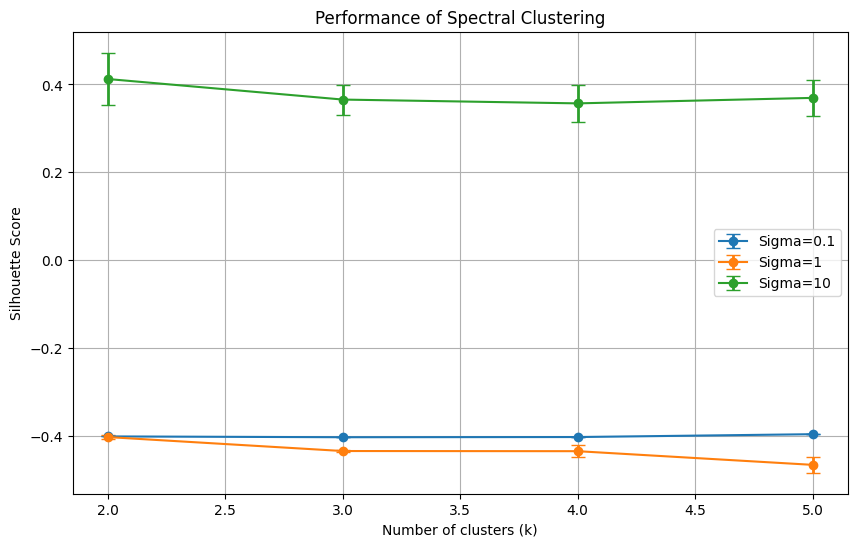

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# affinity matrix using Gaussian similarity function
def gaussian_similarity(X, sigma):
    n_samples = X.shape[0]
    affinity_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            similarity = np.exp(-np.linalg.norm(X[i] - X[j])**2 / (2 * sigma**2))
            affinity_matrix[i][j] = similarity
            affinity_matrix[j][i] = similarity
    return affinity_matrix

# laplacian matrix
def laplacian_matrix(affinity_matrix):
    D = np.diag(np.sum(affinity_matrix, axis=1)) # degree matrix
    return D - affinity_matrix

# eigendecomposition on Laplacian matrix
def spectral_clustering(X, k, sigma):
    affinity_matrix = gaussian_similarity(X, sigma)
    L = laplacian_matrix(affinity_matrix)
    eigval, eigvec = np.linalg.eigh(L)
    indices = np.argsort(eigval)[:k] # indices of k smallest eigenvalues
    embedding = eigvec[:, indices]
    # KMeans on embedded space
    centroids, labels = kmeans(embedding, k)
    return labels

# KMeans implementation
def kmeans(X, k, max_iters=300):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iters):
        # each data point to the closest centroid
        distances = np.linalg.norm(X[:, None, :] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centroids[i] for i in range(k)])
        # check convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, labels

# spectral clustering performance for different values of k and sigma
def evaluate_spectral_clustering(X, k_range, sigma_range, num_trials=10):
    silhouette_scores = np.zeros((len(sigma_range), len(k_range)))
    silhouette_std = np.zeros((len(sigma_range), len(k_range)))
    for i, sigma in enumerate(sigma_range):
        for j, k in enumerate(k_range):
            scores = []
            for _ in range(num_trials):
                labels = spectral_clustering(X, k, sigma)
                score = silhouette_score(X, labels)
                scores.append(score)
            silhouette_scores[i][j] = np.mean(scores)
            silhouette_std[i][j] = np.std(scores)
    return silhouette_scores, silhouette_std

breast_cancer_data = load_breast_cancer()
X = breast_cancer_data.data

k_range = range(2, 6)
sigma_range = [0.1, 1, 10]

# spectral clustering performance
silhouette_scores, silhouette_std = evaluate_spectral_clustering(X, k_range, sigma_range)

plt.figure(figsize=(10, 6))
for i, sigma in enumerate(sigma_range):
    plt.errorbar(k_range, silhouette_scores[i], yerr=silhouette_std[i], label=f'Sigma={sigma}', capsize=5, elinewidth=2, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Performance of Spectral Clustering')
plt.legend()
plt.grid(True)
plt.show()


**Question 4: Anomaly Detection with the Isolation Forest [15 pts]**

I constructed random binary trees to isolate data points. These trees are indicative of the IsolationForest class, which aggregates the results from multiple isolation trees to calculate anomaly scores for each data point. I then removed the top [1%, 5%, 10%, 15%] of anomalies based on their scores and used K-Means++ with $k=2$ to cluster the cleaned data. The performance of the clustering was evaluated using the silhouette score, and this process was repeated ten times to account for random initializations. The mean and standard deviation of the silhouette scores were calculated and plotted to illustrate the impact of anomaly removal on clustering performance.

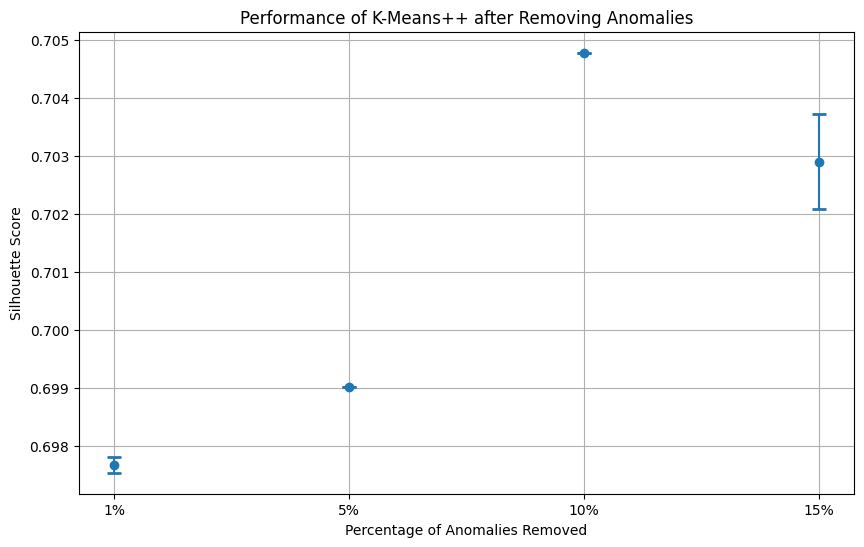

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# create random binary trees
class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X):
        self.tree = self._fit(X, 0)

    def _fit(self, X, depth):
        if depth >= self.max_depth or len(X) <= 1:
            return None

        q = np.random.randint(X.shape[1])
        p = np.random.uniform(X[:, q].min(), X[:, q].max())

        left_mask = X[:, q] < p
        right_mask = ~left_mask

        return {
            'split_at': (q, p),
            'left': self._fit(X[left_mask], depth + 1),
            'right': self._fit(X[right_mask], depth + 1)
        }

    def path_length(self, X):
        return np.array([self._path_length(x, self.tree, 0) for x in X])

    def _path_length(self, x, node, depth):
        if node is None:
            return depth
        q, p = node['split_at']
        if x[q] < p:
            return self._path_length(x, node['left'], depth + 1)
        else:
            return self._path_length(x, node['right'], depth + 1)

# build multiple isolation trees
class IsolationForest:
    def __init__(self, n_estimators=100, max_samples='auto', max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X):
        self.trees = []
        n_samples = X.shape[0]
        if self.max_samples == 'auto':
            self.max_samples = min(256, n_samples)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))

        for _ in range(self.n_estimators):
            subsample_idx = np.random.choice(n_samples, self.max_samples, replace=False)
            X_subsample = X[subsample_idx]
            tree = IsolationTree(self.max_depth)
            tree.fit(X_subsample)
            self.trees.append(tree)

    def anomaly_score(self, X):
        avg_path_length = np.mean([tree.path_length(X) for tree in self.trees], axis=0)
        c_n = 2 * (np.log(self.max_samples - 1) + 0.5772156649) - 2 * (self.max_samples - 1) / self.max_samples
        return 2 ** -(avg_path_length / c_n)

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data

# compute anomaly scores
iso_forest = IsolationForest()
iso_forest.fit(X)
scores = iso_forest.anomaly_score(X)

# remove top [1%, 5%, 10%, 15%] of anomalies
percentiles = [0.01, 0.05, 0.10, 0.15]
X_cleaned_sets = []

for percentile in percentiles:
    threshold = np.percentile(scores, 100 * (1 - percentile))
    X_cleaned = X[scores < threshold]
    X_cleaned_sets.append(X_cleaned)

# K-Means++ implementation
def kmeans_pp(X, k, max_iters=300):
    n_samples, n_features = X.shape
    centroids = np.zeros((k, n_features))
    centroids[0] = X[np.random.choice(n_samples)]

    for i in range(1, k):
        distances = np.min([np.linalg.norm(X - c, axis=1) for c in centroids[:i]], axis=0)
        probabilities = distances / distances.sum()
        centroids[i] = X[np.random.choice(n_samples, p=probabilities)]

    for _ in range(max_iters):
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        labels = np.argmin(distances, axis=0)

        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centroids[i] for i in range(k)])

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

# evaluate performance of K-Means++ on cleaned data sets
def evaluate_kmeans(X_cleaned_sets, num_trials=10):
    silhouette_scores = []
    for X_cleaned in X_cleaned_sets:
        scores = []
        for _ in range(num_trials):
            centroids, labels = kmeans_pp(X_cleaned, k=2)
            score = silhouette_score(X_cleaned, labels)
            scores.append(score)
        silhouette_scores.append((np.mean(scores), np.std(scores)))
    return silhouette_scores

silhouette_scores = evaluate_kmeans(X_cleaned_sets)

percentiles_labels = ['1%', '5%', '10%', '15%']
means = [score[0] for score in silhouette_scores]
stds = [score[1] for score in silhouette_scores]

plt.figure(figsize=(10, 6))
plt.errorbar(percentiles_labels, means, yerr=stds, fmt='o', capsize=5, capthick=2)
plt.xlabel('Percentage of Anomalies Removed')
plt.ylabel('Silhouette Score')
plt.title('Performance of K-Means++ after Removing Anomalies')
plt.grid(True)
plt.show()
